In [1]:
# Imports
import sqlite3 as lite
import pandas as pd
import re
import numpy as np
import ast

In [2]:
conn = lite.connect('cycling_big.db')

riders_df = pd.read_sql_query('SELECT * FROM riders;', conn)
races_df = pd.read_sql_query('SELECT * FROM race_results', conn)

print("Amount of rows in races_df: ", races_df[races_df.columns[0]].count())
print("Amount of rows in riders_df: ", riders_df[riders_df.columns[0]].count())

conn.close()

"""
Convert the 'Date' column to DateTime format
Regarding races_df dataframe!
"""

races_df['Date'] = pd.to_datetime(races_df['Date'], errors='coerce', format='%d %B %Y')

# Remove rows where 'Date' is NaT
races_df = races_df.dropna(subset=['Date'])

# Normalize 'Date' to strip out time if it's present (this keeps just the date part)
races_df['Date'] = races_df['Date'].dt.normalize()

# Extract the month and year from the column and put them in their own columns
races_df['Month'] = races_df['Date'].dt.month
races_df['Year'] = races_df['Date'].dt.year

print("Unique values for 'months': ", races_df['Month'].unique(), "\n")
print("Unique values for 'years': ",races_df['Year'].unique())

"""
Converting the timetable to total seconds
"""

def time_to_seconds(time_str):
    # Remove commas and any spaces
    time_str = time_str.replace(',', '').strip()

    # Check the consistency of the time format using regular expressions
    match = re.match(r'(\d{1,2}):(\d{2}):(\d{2})', time_str)
    if match:
        hours, minutes, seconds = map(int, match.groups())
        total_seconds = hours * 3600 + minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan
        return total_seconds

    # Do the same as the loop above, but now for MM:SS format.
    match = re.match(r'(\d{1,2}):(\d{2})', time_str)
    if match:
        minutes, seconds = map(int, match.groups())
        total_seconds = minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan  
        return total_seconds

    # Do the same but for 0:00, 0:01, etc.
    match = re.match(r'(\d{1,2}):(\d{1,2})', time_str)
    if match:
        minutes, seconds = map(int, match.groups())
        total_seconds = minutes * 60 + seconds
        if total_seconds == 0:
            return np.nan 
        return total_seconds
    
    # If format doesn't match, return NaN
    return np.nan

# Apply the conversion function to the 'Time' column
races_df['Time_seconds'] = races_df['Time'].apply(time_to_seconds)

# print(races_df[['Time', 'Time_seconds']].head(10))
# races_df.info()

"""
Converting timelag to total seconds
"""

def timelag_to_seconds(timelag_str):
    # Check if the timelag_str contains missing values
    if pd.isna(timelag_str):
        return np.nan

    timelag_str = timelag_str.lstrip('+').strip()

    match = re.match(r'(\d{1,2}):(\d{2}):(\d{2})', timelag_str)
    if match:
        hours, minutes, seconds = map(int, match.groups())
        return hours * 3600 + minutes * 60 + seconds

    match = re.match(r'(\d{1,2}):(\d{2})', timelag_str)
    if match:
        minutes, seconds = map(int, match.groups())
        return minutes * 60 + seconds
    
    match = re.match(r'(\d+):(\d+)', timelag_str)
    if match:
        minutes, seconds = map(int, match.groups())
        return minutes * 60 + seconds

    return np.nan

races_df['Timelag_seconds'] = races_df['Timelag'].apply(timelag_to_seconds)

races_df['Timelag_seconds'] = races_df['Timelag_seconds'].replace(0.0, np.nan)

print(races_df[['Timelag', 'Timelag_seconds']].head(10))

"""
Converting distance into single numerical value
This means stripping 'km' from string and converting the remaining values into float64
"""

races_df['Length'] = races_df['Length'].str.replace(' km', '', regex=False)

# Convert to numeric and replace 0 with NaN
races_df['Length'] = pd.to_numeric(races_df['Length'], errors='coerce')  # Convert to numeric and handle errors

# Replace 0 values with NaN
races_df['Length'] = races_df['Length'].replace(0.0, np.nan)

# print(races_df['Length'])

"""
Splitting values from 'rdr' and putting the split values into separate columns
"""

# Function to convert the 'rdr' string to separate ranking columns
def extract_rankings(rdr_str):
    try:
        # Converting str to dict
        rankings = ast.literal_eval(rdr_str)
        
        # Extracting ranks, while also handling missing keys
        pcs_rnk = rankings.get('PCS Ranking', np.nan)
        uci_rnk = rankings.get('UCI World Ranking', np.nan)
        alltime_rnk = rankings.get('Specials | All Time Ranking', np.nan)
        
        return pd.Series([pcs_rnk, uci_rnk, alltime_rnk])
    except:
        return pd.Series([np.nan, np.nan, np.nan])

# Apply the function to the 'rdr' column
riders_df[['PCS_Rnk', 'UCI_Rnk', 'AllTime_Rnk']] = riders_df['rdr'].apply(extract_rankings)

# Entries should be turned into numeric values, where errors get turned into NaN
riders_df['PCS_Rnk'] = pd.to_numeric(riders_df['PCS_Rnk'], errors='coerce')
riders_df['UCI_Rnk'] = pd.to_numeric(riders_df['UCI_Rnk'], errors='coerce')
riders_df['AllTime_Rnk'] = pd.to_numeric(riders_df['AllTime_Rnk'], errors='coerce')

# print(riders_df[['fullname', 'PCS_Rnk', 'UCI_Rnk', 'AllTime_Rnk']])

"""
Convert stage types to binary with label encoding
"""

races_df['Stage_Type_bin'] = races_df['Stage_Type'].map({'RR': 0, 'ITT': 1})

"""
Splitting values from 'pps' and putting those values into separate columns.
"""

def extract_points(pps_str):
    try:
        points = ast.literal_eval(pps_str)
        
        day_pnt = np.nan if points.get('One day races', '0') == '0' else points.get('One day races', np.nan)
        gc_pnt = np.nan if points.get('GC', '0') == '0' else points.get('GC', np.nan)
        tt_pnt = np.nan if points.get('Time trial', '0') == '0' else points.get('Time trial', np.nan)
        sprint_pnt = np.nan if points.get('Sprint', '0') == '0' else points.get('Sprint', np.nan)
        climb_pnt = np.nan if points.get('Climber', '0') == '0' else points.get('Climber', np.nan)
        
        return pd.Series([day_pnt, gc_pnt, tt_pnt, sprint_pnt, climb_pnt])
    except:
        return pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan])

riders_df[['Day_Pnt', 'GC_Pnt', 'TT_Pnt', 'Sprint_Pnt', 'Climb_Pnt']] = riders_df['pps'].apply(extract_points)

riders_df['Day_Pnt'] = pd.to_numeric(riders_df['Day_Pnt'], errors='coerce')
riders_df['GC_Pnt'] = pd.to_numeric(riders_df['GC_Pnt'], errors='coerce')
riders_df['TT_Pnt'] = pd.to_numeric(riders_df['TT_Pnt'], errors='coerce')
riders_df['Sprint_Pnt'] = pd.to_numeric(riders_df['Sprint_Pnt'], errors='coerce')
riders_df['Climb_Pnt'] = pd.to_numeric(riders_df['Climb_Pnt'], errors='coerce')


Amount of rows in races_df:  225918
Amount of rows in riders_df:  1042
Unique values for 'months':  [ 1  3  4  5  6  7  8  9 10] 

Unique values for 'years':  [2012 2014 2015 2017 2018 2020 2021]
  Timelag  Timelag_seconds
0   +0:00              NaN
1   +0:04              4.0
2   +0:06              6.0
3   +0:10             10.0
4   +0:10             10.0
5   +0:10             10.0
6   +0:10             10.0
7   +0:10             10.0
8   +0:10             10.0
9   +0:10             10.0


In [3]:
print(riders_df['fullname'])

0          BARDET Romain
1        DUMOULIN Samuel
2          GALLOPIN Tony
3          NAESEN Oliver
4          FRANK Mathias
              ...       
1037      TRONDSEN Trond
1038    VAN MELSEN Kévin
1039     BEULLENS Cédric
1040    DE WINTER Ludwig
1041      DELACROIX Théo
Name: fullname, Length: 1042, dtype: object


In [4]:
riders_df['fullname'] = riders_df['fullname'].str.replace(' ', '_') 
print(riders_df['fullname'])

0          BARDET_Romain
1        DUMOULIN_Samuel
2          GALLOPIN_Tony
3          NAESEN_Oliver
4          FRANK_Mathias
              ...       
1037      TRONDSEN_Trond
1038    VAN_MELSEN_Kévin
1039     BEULLENS_Cédric
1040    DE_WINTER_Ludwig
1041      DELACROIX_Théo
Name: fullname, Length: 1042, dtype: object


In [5]:
"""
Join the rider and race tables together, using the rider_id as an index
"""
print("Amount of rows in races_df post cleanup: ", races_df[races_df.columns[0]].count())
print("Amount of rows in riders_df post cleanup: ", riders_df[riders_df.columns[0]].count())

df = races_df.set_index('rider_id').join(riders_df.set_index('rider_id'), how = 'left')

print("Amount of rows in df: ", df[df.columns[0]].count())

"""
Dropping columns that are not needed for analysis
"""

# Note: fix the long list
df.drop(['Time', 'Timelag', 'rdr', 'pps', 'birthdate', 'rider_url', 'Race_url', 'Stage_url', 'Circuit', 'Race_Name', 'Stage_Name', 'Start', 'Finish', 'Category', 'Stage_Type'], axis=1, inplace=True)

# Additional drops:
df = df.drop(columns=['id', 'Team', 'Date', 'Race_ID', 'Stage_Number', 'Team'])
# Replace all remaining zero values with NaN
df = df.replace(0, np.nan)

print(df.isna().sum())
print("Amount of rows in df after cleanup: ", df[df.columns[0]].count())
print("\ndone")

Amount of rows in races_df post cleanup:  80174
Amount of rows in riders_df post cleanup:  1042
Amount of rows in df:  80174
Rnk                    0
GC                 10059
BiB                    0
Rider                  0
Age                    0
UCI                77527
Pnt                69767
Length              6495
Month                  0
Year                   0
Time_seconds       18435
Timelag_seconds    11212
Stage_Type_bin     72484
fullname           34208
team               34208
country            34208
height             34260
weight             34266
PCS_Rnk            45842
UCI_Rnk            46804
AllTime_Rnk        53300
Day_Pnt            34216
GC_Pnt             34208
TT_Pnt             34631
Sprint_Pnt         34342
Climb_Pnt          34365
dtype: int64
Amount of rows in df after cleanup:  80174

done


### PI 7: Part 3


#### 1.1 Appropriate Machine Learning Models
In this section, the selection of appropriate machine learning models in the context of the current dataset will be discussed.

#### 1.2.1 Categorical and Regression Trees
For the first model, the use of Categorical and Regression Trees will be discussed. As stated in *part 2* of the assignment, CART is a decision tree, that classifies records based on the conditions in the *decision nodes*, where the final classification, or regression, is determined in the *leaf nodes*. See the code from <code>pi7-2.ipynb</code> for a more in-depth explanation of decision trees.

#### 1.2.2 Argumentation
A regression tree will be implemented due to the following reasons:
- Handling possible non-linear relationships.
- It does not require any normalization/standardization, making outcomes more interpretable.
- It can handle outliers and missing values well.

Arguments against implementing regression trees:
- The more complex a tree becomes, the more prone it becomes to overfitting. There are methods for handling scenarios where overfitting can become an issue, like *pruning*.
- Sensitive to hyperparameters.
- Unsuitable for datasets with a large number of classes (see the arguments above).

#### 1.2.3 Implementation
Below is am implementation of a regression tree on the current dataset.

In [6]:
df.isnull().sum()

Rnk                    0
GC                 10059
BiB                    0
Rider                  0
Age                    0
UCI                77527
Pnt                69767
Length              6495
Month                  0
Year                   0
Time_seconds       18435
Timelag_seconds    11212
Stage_Type_bin     72484
fullname           34208
team               34208
country            34208
height             34260
weight             34266
PCS_Rnk            45842
UCI_Rnk            46804
AllTime_Rnk        53300
Day_Pnt            34216
GC_Pnt             34208
TT_Pnt             34631
Sprint_Pnt         34342
Climb_Pnt          34365
dtype: int64

'Rnk' or final rank will be used as our predictor variable. This column still contains alot of numerical values for 'DNF', meaning this will need to get cleaned up. Removing non-numericals, like DNF, DNS and OTL, does not impact the amount of available data by a large amount, so we will result in dropping these entries. Since these entries will most likely not contain any useful information (since the rider never finished or fouled), these entries will be dropped.

In [7]:
df['Rnk'].isna().sum()

np.int64(0)

In [8]:
df['Rnk'] = pd.to_numeric(df['Rnk'], errors='coerce')

In [9]:
df['Rnk'].isna().sum()

np.int64(5219)

It might also be a good idea to distinguish between two different types of races: Road Race (RR) and Individual Time Trial (ITT). It's a possibility that some riders are more specialized in races and others in time trials, so to potentially improve accuracy, the dataframe will be split into two separate dataframes. For the machine learning models, RR will be used.

In [10]:
""" df_rr = df[df['Stage_Type'] == 'RR'].drop(columns='Stage_Type', axis=1)
df_itt = df[df['Stage_Type'] == 'ITT'].drop(columns='Stage_Type', axis=1) """

" df_rr = df[df['Stage_Type'] == 'RR'].drop(columns='Stage_Type', axis=1)\ndf_itt = df[df['Stage_Type'] == 'ITT'].drop(columns='Stage_Type', axis=1) "

Regression will be used to determine the outcome rank for riders. To do this, a new dataframe will be created to define the predictors of which we think are important for the outcome rank.

To make it simple for our regression tree, the outcome will be based on the personal ranking  and points predictors, height and weight and average time(lag).

In [11]:
dtr_drop = ['GC', 'BiB', 'UCI', 'Pnt', 'Rider', 'fullname', 'team', 'country', 'Length', 'Month', 'Year', 'Stage_Type_bin']
            #, 'Day_Pnt', 'GC_Pnt', 'TT_Pnt', 'Sprint_Pnt', 'Climb_Pnt']
df_ml = df.drop(columns=dtr_drop)

df_ml.isnull().sum()
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80174 entries, 659ed585810c65fe22255a5e4a9b7838 to 0292146b9196ec7a98903cb50dae48cd
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rnk              74955 non-null  float64
 1   Age              80174 non-null  int64  
 2   Time_seconds     61739 non-null  float64
 3   Timelag_seconds  68962 non-null  float64
 4   height           45914 non-null  float64
 5   weight           45908 non-null  float64
 6   PCS_Rnk          34332 non-null  float64
 7   UCI_Rnk          33370 non-null  float64
 8   AllTime_Rnk      26874 non-null  float64
 9   Day_Pnt          45958 non-null  float64
 10  GC_Pnt           45966 non-null  float64
 11  TT_Pnt           45543 non-null  float64
 12  Sprint_Pnt       45832 non-null  float64
 13  Climb_Pnt        45809 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 9.2+ MB


In [12]:
df[dtr_drop].isnull().count()

GC                80174
BiB               80174
UCI               80174
Pnt               80174
Rider             80174
fullname          80174
team              80174
country           80174
Length            80174
Month             80174
Year              80174
Stage_Type_bin    80174
dtype: int64

In [13]:
df_ml = df_ml.dropna()
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14138 entries, a73d590113699f02caf57566c20a2ae7 to d6d7a1bb41a96c4bd23470d2c2eb58e8
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rnk              14138 non-null  float64
 1   Age              14138 non-null  int64  
 2   Time_seconds     14138 non-null  float64
 3   Timelag_seconds  14138 non-null  float64
 4   height           14138 non-null  float64
 5   weight           14138 non-null  float64
 6   PCS_Rnk          14138 non-null  float64
 7   UCI_Rnk          14138 non-null  float64
 8   AllTime_Rnk      14138 non-null  float64
 9   Day_Pnt          14138 non-null  float64
 10  GC_Pnt           14138 non-null  float64
 11  TT_Pnt           14138 non-null  float64
 12  Sprint_Pnt       14138 non-null  float64
 13  Climb_Pnt        14138 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 1.6+ MB


In [32]:
X = df_ml.iloc[:, 1:13] # adjust row val
y = df_ml.iloc[:, 0]

To remove outliers and improve our error rating, outlier will be detected and subsequently removed using *isolation forest*.

For <code>contamination</code>, it will be assumed that 6% of our data contains outliers. 

In [39]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(contamination=0.1, random_state=42)

iforest.fit(X, y)

iforest_predict = iforest.predict(X)

X_clean = X[iforest_predict == 1]
y_clean = y[iforest_predict == 1]

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, random_state=42, train_size=0.8)

In [41]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

dtr = DecisionTreeRegressor().fit(X_clean, y_clean)

y_pred = dtr.predict(X_test)

Mean squared error:  0.6282919488337095 
 Mean absolute error:  0.02984700275896664

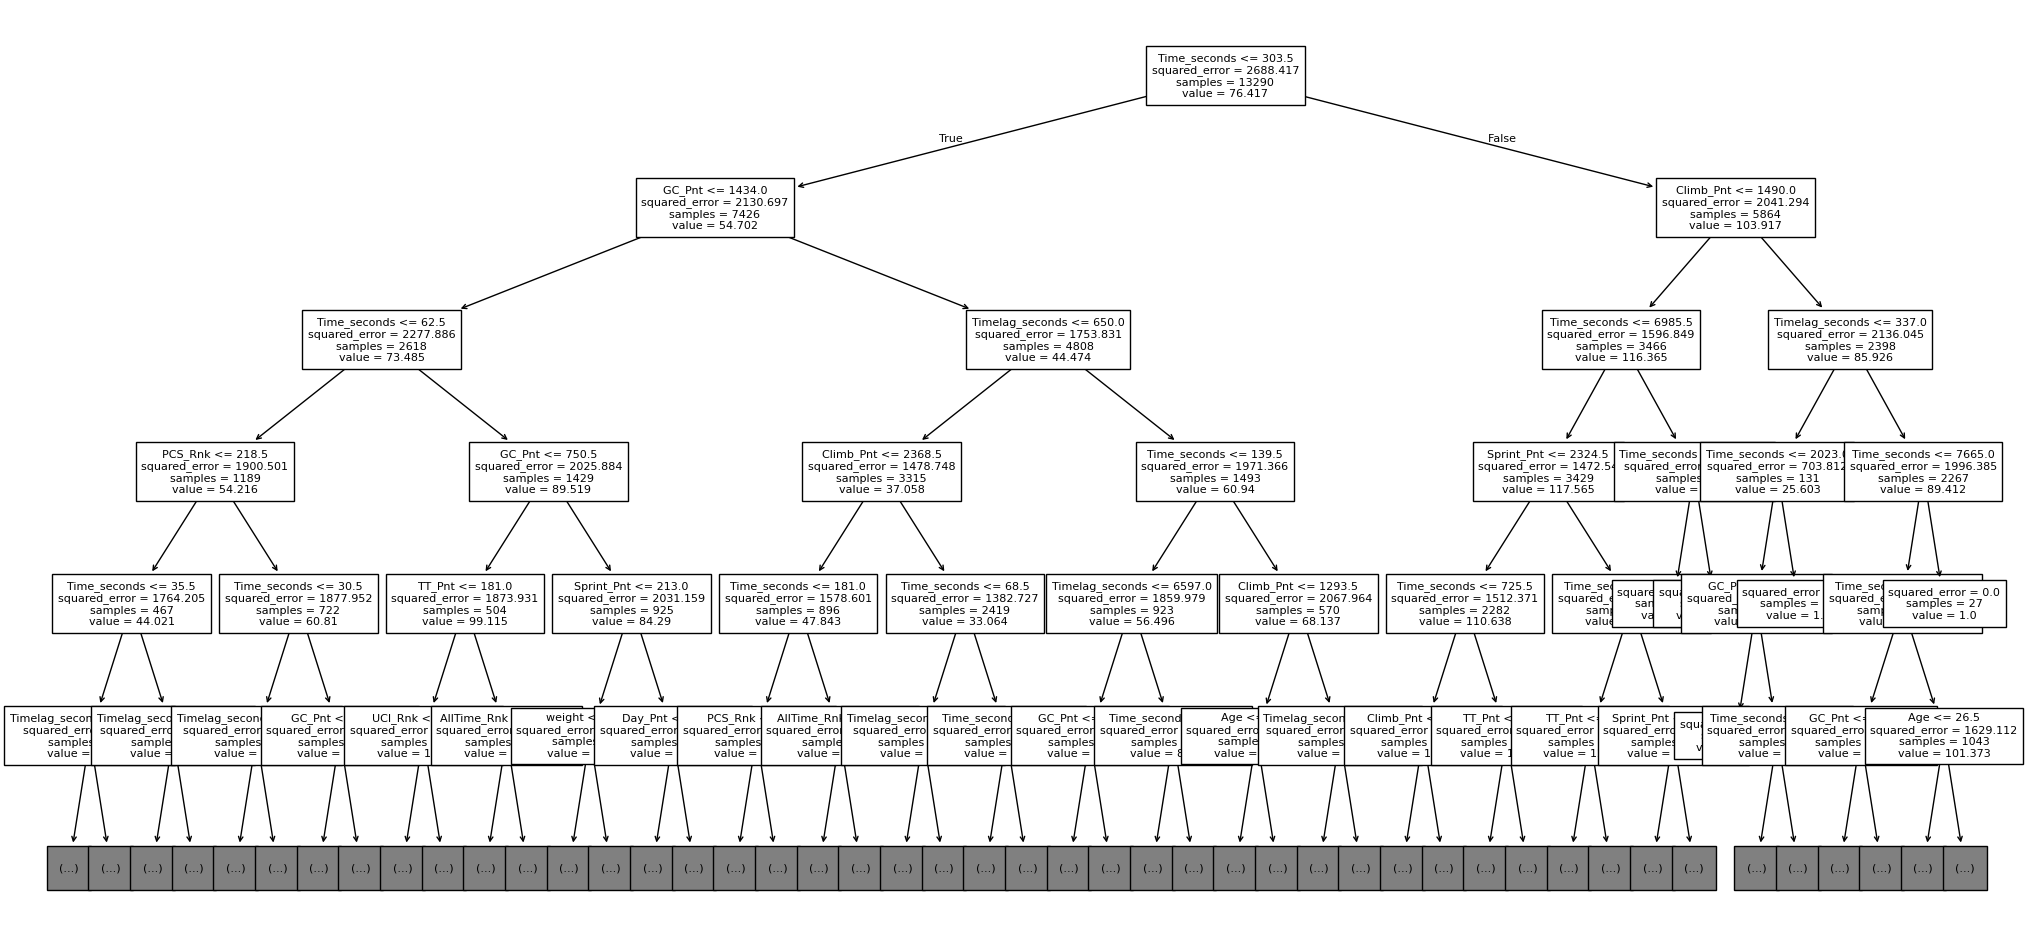

In [19]:
feature_names = df_ml.columns[1:16].tolist()

plt.figure(figsize=(25,12))
plot_tree(dtr, fontsize=8, max_depth=5, feature_names=X.columns)
plt.show()

And this is only the tip of the iceberg ... 

The tree above does give a nice representation of the root split and its subsequent decision nodes. It can be noted that for this tree, "Time_seconds" was chosen as the most significant split. This might give some explanation why there is still significant error in the dataset. For the training of the model, the distinction between Individual Time Trials (ITT) and Road Races (RR) was not taken into account. ITTs tend to last a fair bit shorter compared to RRs, meaning that this could potentially make it harder for the model to accurately predict rankings, based on the total time a rider took to finish an event.

#### 1.3.1 Histogram-based Gradient Boosting Regression


In the following section, *Histogram-based Gradient Boosting Regression* will be discussed. 

This machine learning model makes use of *gradient boosting* and the construction of histogram-based features.

*Gradient boosting* is an ensemble method which makes use of regression trees. 

**What is ensemble learning?**
- Ensemble learning is a model that will construct a number of models, with the aim to improve its prediction rate.
Two popular ensemble methods include *bagging* (Bootstrap Aggregation) and *boosting*. With bagging, weak models are trained in parallel, where each model learns from a given partition of the dataset. The results from each of these models are then combined by either averaging (regression) or voting (classification). With boosting, a sequential method, each model is trained on a weighted training set, where each model corrects the weights based on the error from its predecessors.


Gradient boosting is a boosting method, which works by building multiple, weaker, prediction models in sequence. Each time a model is constructed, it will (try to) predict the error that is left over by its model, and uses this information to build the next model. Gradient boosting makes use of combining predictions of multiple weak learners, usually decision trees.


**How does Hist Gradient Boosting work?**
This model is similar to gradient boosting, as it is an ensemble technique which uses boosting, but instead of using decision trees as weak learners, it makes use of histograms. Using histograms is computationally more efficient, making it faster compared to traditional gradient boosting, especially on larger datasets. Building a histogram has a notation of $O(nfeatures​×n)$, whereas gradient boosting is of $O(nfeatures​×nlog(n))$.

#### 1.3.2 Argumentation
- Faster training times.
- It can handle larger datasets.
- Data does not need to be normalized.
- Histogram-based can handle non-linear interaction.

#### 1.3.3 Implementation
See below for the implementation of histogram-based gradient boosting.

In [46]:
X_train.shape, y_train.shape

((10179, 12), (10179,))

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
est = HistGradientBoostingRegressor().fit(X_train, y_train)
est.score(X_test, y_test)

0.5026657240371293

For testing purposes, the $R^2$ score, which returns the coefficient of determination of the prediction, was included in the codeblock above. More on metrics will follow in **2.1 Metrics for Models**.

#### 1.4 Support Vector Regression (SVR)
In the following section, SVR will be discussed and showcased.

SVR is a type of learning model, found in the set of models from Support Vector Machines (SVM). SVM is a supervised model that can handle noth unstructured data as well as nonlinear relationships in high dimensional spaces. This is made possible due to a nifty feature of this type of model: the *kernel trick* or also called *kernel method*.

#### The Kernel Method
The kernel method aims to solve two problems with on solution.
**Problem 1**: 
relies on a nonlinear transformation of the points in a dataset. Say X and Y are plotted against on another. By 

In [24]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svr.fit(X_train, y_train)

SVR(epsilon=0.2)

#### 2.1 Metrics for Models

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean squared error: ", mse, "\nMean absolute error: ", mae, "\nR2 score: ", r2)

Mean squared error:  0.6543222003929273 
Mean absolute error:  0.04027504911591356 
R2 score:  0.9997473942868526


In [23]:
gb_reg.score(X_test, y_test)

0.46536016561528937

In [22]:
gb_reg.predict(X_test)

array([ 40.09003403,  78.34610663,  42.92892229, ...,  64.19940513,
        99.01402806, 108.08487911], shape=(2658,))

As sean above R-squared returns ~0.4349, which in general means that around 43,5% of the variance is explained in the test set, meaning there is some predictive power to the modelm there is still a fair amount of variance and error unaccounted for.

#### 3.1 Cross-validation

#### 4.1 Ideal Hyperparameters

#### 5.1 Conclusions

#### Bibliography:
Chicco, D., Warrens, M. J., & Jurman, G. (2021). The Coefficient of Determination R-squared Is More Informative than SMAPE, MAE, MAPE, MSE and RMSE in Regression Analysis Evaluation. *PeerJ Computer Science, 7(5)*, e623. ncbi. https://doi.org/10.7717/peerj-cs.623


‌*Ensembles: Gradient boosting, random forests, bagging, voting, stacking*. (2022). Scikit-Learn. 
    https://scikit-learn.org/stable/modules/ensemble.html#gradientboostingclassifier-and-gradientboostingregressor


*HistGradientBoostingRegressor*. (n.d.). Scikit-Learn. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html


*Support Vector Regression - Coastal Wiki.* (2024). Coastalwiki.org. https://www.coastalwiki.org/wiki/Support_Vector_Regression


*The Kernel Trick in Support Vector Machine (SVM).* (2022, May 9).  YouTube. https://youtu.be/Q7vT0--5VII?si=UPm5UYwL1Dtsgkhw

‌